# Map cards
- [x] Get lat, long, county for each office (`rfc_loan_agencies`)
- [x] Get lat, long, county for each index (`gi_geonormed.csv`)
- [x] Spatial join with county geometries (polygons) (`US_county_1950.shp` | `tl_2019_us_county.shp`), change projection
- [ ] Make static and interactive choropleth map of mortgages by county

Next steps
- clean up lender info from cards
- map mortgage lender "service areas"
    

In [198]:
from tqdm import tqdm
import pandas as pd
import geopandas as gpd # spatial data handling
import matplotlib.pyplot as plt
import geopy # spatial data analysis
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance
from shapely import speedups
from ipyleaflet import Map, GeoJSON, GeoData, basemaps, basemap_to_tiles, LayersControl, Choropleth # interactive mapping
import ipywidgets
from ipywidgets.embed import embed_minimal_html # for saving map
from branca.colormap import linear

In [79]:
tqdm.pandas()

In [3]:
DIR = "../mapping"

Test OSM geocoding service

In [4]:
# test_in = "Philadelphia, PA"
# test_out = Nominatim(user_agent="slafia@umich.edu").geocode(test_in)
# print(test_out.address)

Load and geocode the (1) RFC loan offices dataframe; and (2) GI index cards. Available fields from OSM:
- address (city, county, state)
- longitude 
- latitude
- point (minutes, seconds)
- raw (metadata)

In [ ]:
df_rfc = pd.read_csv(DIR+'/rfc_loan_agencies.csv') # RFC loan locations
geocoder = RateLimiter(Nominatim(user_agent="slafia@umich.edu").geocode, min_delay_seconds=1) # agent is user id

df_rfc["Location"] = df_rfc["Edited"].progress_apply(geocoder) # geocode place names
df_rfc["Address"] = df_rfc["Location"].progress_apply(lambda loc: loc.address if loc else None)
df_rfc["Latitude"] = df_rfc["Location"].progress_apply(lambda loc: loc.latitude if loc else None)
df_rfc["Longitude"] = df_rfc["Location"].progress_apply(lambda loc: loc.longitude if loc else None)

df_rfc = df_rfc[["Address","Latitude","Longitude"]] # simplify dataframe
df_rfc.to_csv(DIR+'/df_rfc_geocoded.csv',index=False) # save output
gdf_rfc = gpd.GeoDataFrame(df_rfc, geometry=gpd.points_from_xy(df_rfc.Longitude, df_rfc.Latitude)) # convert to geo
gdf_rfc

100%|███████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 49283.72it/s]


,Address,Latitude,Longitude,geometry
0,"Atlanta, Fulton County, Georgia, United States",33.748992,-84.390264,POINT (-84.39026 33.74899)
1,"Jacksonville, Duval County, Florida, United St...",30.332184,-81.655651,POINT (-81.65565 30.33218)
2,"Philadelphia, Philadelphia County, Pennsylvani...",39.952724,-75.163526,POINT (-75.16353 39.95272)
3,"Birmingham, Jefferson County, Alabama, United ...",33.520682,-86.802433,POINT (-86.80243 33.52068)
4,"Kansas City, Jackson County, Missouri, United ...",39.100105,-94.578142,POINT (-94.57814 39.10010)
5,"Portland, Multnomah County, Oregon, United States",45.520247,-122.674194,POINT (-122.67419 45.52025)
6,"Boston, Suffolk County, Massachusetts, United ...",42.355433,-71.060511,POINT (-71.06051 42.35543)
7,"Little Rock, Pulaski County, Arkansas, United ...",34.746507,-92.289627,POINT (-92.28963 34.74651)
8,"Richmond, Virginia, United States",37.538509,-77.434280,POINT (-77.43428 37.53851)
9,"Charlotte, Mecklenburg County, North Carolina,...",35.227209,-80.843083,POINT (-80.84308 35.22721)


Drop duplicate place names to reduce requests

In [6]:
df_card = pd.read_csv(DIR+'/gi_geonormed.csv') # GI mortgage locations
df_card = df_card.dropna(subset=["cen_place", "state_alpha"])
df_card["cen_place"] = df_card["cen_place"].astype(str)
df_card["state_alpha"] = df_card["state_alpha"].astype(str)
df_card["Edited"] = df_card["cen_place"] + ", " + df_card["state_alpha"]

df_card.cen_place.value_counts() # which places are most frequent

df_card = df_card.groupby(df_card["Edited"].tolist(),as_index=False).size()
df_card = df_card.rename(columns={"index":"Edited","size":"Count"})

geocoder = RateLimiter(Nominatim(user_agent="slafia@umich.edu").geocode, min_delay_seconds=1)

df_card["Location"] = df_card["Edited"].progress_apply(geocoder) # geocode place names

df_card["Address"] = df_card["Location"].progress_apply(lambda loc: loc.address if loc else None)
df_card["Latitude"] = df_card["Location"].progress_apply(lambda loc: loc.latitude if loc else None)
df_card["Longitude"] = df_card["Location"].progress_apply(lambda loc: loc.longitude if loc else None)

df_card = df_card[["Address","Latitude","Longitude","Count"]] # simplify dataframe
df_card.to_csv(DIR+'/df_card_geocoded.csv',index=False) # save output
gdf_card = gpd.GeoDataFrame(df_card, geometry=gpd.points_from_xy(df_card.Longitude, df_card.Latitude)) # convert to geo
gdf_card

 86%|████████████████████████████████████████████████████████████▎         | 1458/1693 [24:25<04:17,  1.09s/it]RateLimiter caught an error, retrying (0/2 tries). Called with (*('SPRINGFIELD, MO',), **{}).
Traceback (most recent call last):
  File "/Users/slafia/miniconda3/envs/spatial/lib/python3.11/site-packages/urllib3/connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/Users/slafia/miniconda3/envs/spatial/lib/python3.11/site-packages/urllib3/connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
                       ^^^^^^^^^^^^^^^^^^
  File "/Users/slafia/miniconda3/envs/spatial/lib/python3.11/http/client.py", line 1375, in getresponse
    response.begin()
  File "/Users/slafia/miniconda3/envs/spatial/lib/python3.11/http/client.py", line 318, in begin
    version, status, reason = self._read_status()
                              ^^^^^^^^^^^^^^^^^^^
  File "/Users/slafia/min

,Address,Latitude,Longitude,Count,geometry
0,"Aberdeen, Harford County, Maryland, United States",39.512035,-76.164329,1,POINT (-76.16433 39.51203)
1,"Abilene, Dickinson County, Kansas, United States",38.917252,-97.213770,11,POINT (-97.21377 38.91725)
2,"Abilene, Taylor County, Texas, United States",32.446450,-99.747591,5,POINT (-99.74759 32.44645)
3,"Acworth, Cobb County, Georgia, United States",34.065933,-84.676880,2,POINT (-84.67688 34.06593)
4,"Ada, Pontotoc County, Oklahoma, 74820, United ...",34.774338,-96.678365,2,POINT (-96.67837 34.77434)
...,...,...,...,...,...
1688,"City of Yonkers, Westchester County, New York,...",40.931210,-73.898747,1,POINT (-73.89875 40.93121)
1689,"York County, South Carolina, United States",34.960329,-81.165541,8,POINT (-81.16554 34.96033)
1690,"Ypsilanti, Washtenaw County, Michigan, 48197, ...",42.241056,-83.613055,4,POINT (-83.61306 42.24106)
1691,"Yukon, Canadian County, Oklahoma, United States",35.506726,-97.762539,3,POINT (-97.76254 35.50673)


Load and set projections for geometries
- U.S. counties
    - current 2023 (from U.S. Census) [polygons](https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-current-county-and-equivalent-national-shapefile)
    - historical 1950 (from IPUMS NHGIS) [polygons](https://www.nhgis.org/)
- RFC offices 
- card locations

In [210]:
# RELOAD POINTS
df_card = pd.read_csv(DIR+'/df_card_geocoded.csv')
gdf_card = gpd.GeoDataFrame(df_card, geometry=gpd.points_from_xy(df_card.Longitude, df_card.Latitude)) # GI mortgage locations

df_rfc = pd.read_csv(DIR+'/df_rfc_geocoded.csv')
gdf_rfc = gpd.GeoDataFrame(df_rfc, geometry=gpd.points_from_xy(df_rfc.Longitude, df_rfc.Latitude)) # RFC office locations

# REPROJECT POINTS
gdf_card = gdf_card.set_crs(4269, allow_override=True)
gdf_rfc = gdf_rfc.set_crs(4269, allow_override=True)

# LOAD POLYGONS
# fp = DIR+"/tl_2019_us_county/tl_2019_us_county.shp" # current
fp = DIR+"/nhgis0001_shapefile/US_county_1950.shp" # historical
counties = gpd.read_file(fp).reset_index()
county_id_field = 'index'

# REPROJECT POLYGONS
counties = counties.to_crs(4269) # reproject from ESRI:102003 to EPSG:4269
counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3111 entries, 0 to 3110
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       3111 non-null   int64   
 1   DECADE      3111 non-null   object  
 2   NHGISNAM    3111 non-null   object  
 3   NHGISST     3111 non-null   object  
 4   NHGISCTY    3111 non-null   object  
 5   ICPSRST     3111 non-null   object  
 6   ICPSRCTY    3111 non-null   object  
 7   ICPSRNAM    3111 non-null   object  
 8   STATENAM    3111 non-null   object  
 9   ICPSRSTI    3111 non-null   int64   
 10  ICPSRCTYI   3111 non-null   int64   
 11  ICPSRFIP    3111 non-null   float64 
 12  STATE       3103 non-null   object  
 13  COUNTY      3103 non-null   object  
 14  PID         3111 non-null   float64 
 15  X_CENTROID  3111 non-null   float64 
 16  Y_CENTROID  3111 non-null   float64 
 17  GISJOIN     3111 non-null   object  
 18  GISJOIN2    3111 non-null   object  
 19

Spatial join
- mortgage card locations (points)
- U.S. counties (polygons)

In [211]:
sjoin = gpd.sjoin(counties, gdf_card, how='left', op='intersects')
count = sjoin.groupby(county_id_field)[county_id_field].count()
count.name='pointcount'
counties = pd.merge(left=counties, right=count, left_on=county_id_field, right_index=True)

/Users/slafia/miniconda3/envs/spatial/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


Display a static plot with layers
- looks like some of the cards were not properly geocoded. we can revisit and fix these
- select one county for inspection; Detroit was the most frequent in the cards so let's pick Wayne

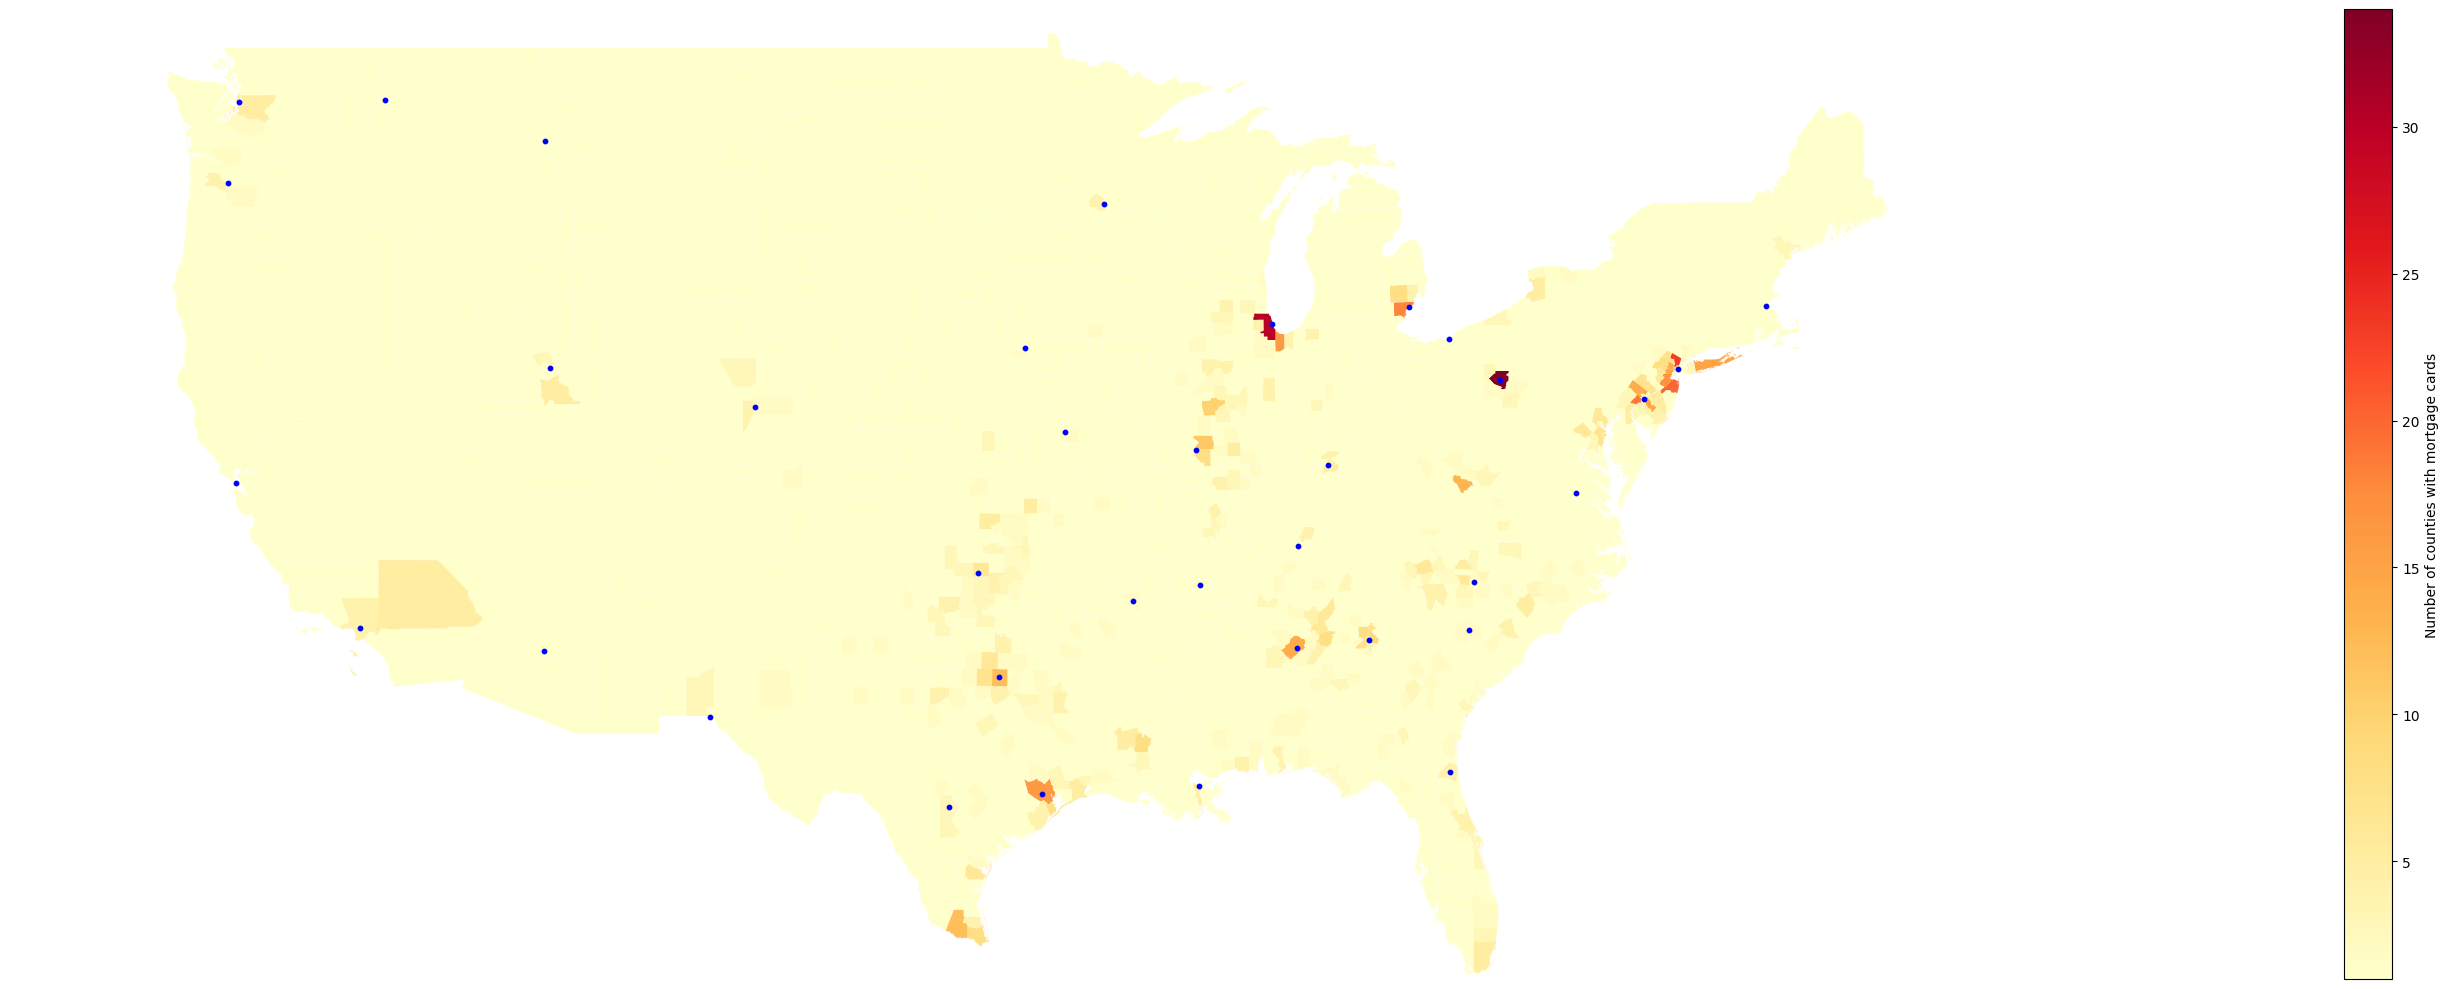

In [227]:
# Create a figure with one subplot
fig, ax = plt.subplots(figsize = (50,10))

# Plot polygons
# counties.plot(ax=ax, facecolor='gray');
counties.plot(ax=ax, column = 'pointcount', cmap = 'YlOrRd', legend=True, 
              legend_kwds={'label':'Number of counties with mortgage cards'})
counties.geometry.boundary.plot(color=None, edgecolor='k',linewidth = 0, ax=ax);

# Plot points
gdf_rfc.plot(ax=ax, color='blue', markersize=10)
# gdf_card.plot(ax=ax, color='red', markersize=5)

ax.set_xlim([-130, -60])
ax.set_ylim([25, 50])

plt.axis('off')
plt.tight_layout()
plt.savefig(DIR+"/mortgages_by_county.png", bbox_inches='tight')


Display an interactive map with layers:
- RFC offices
- GI mortgage locations
- U.S. states and counties

In [228]:
m = Map(# basemap=basemap_to_tiles(basemaps.CartoDB.VoyagerLabelsUnder),  # initialize map
        center=(39, -95), 
        zoom=4)

geo_data_rfc = GeoData(geo_dataframe = gdf_rfc, # set the points style
    style={'color': 'blue', 'radius':5, 'fillColor': 'blue', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 5, 'color': 'blue', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    name = 'RFC offices')

geo_data_card = GeoData(geo_dataframe = gdf_card, # set the points style
    style={'color': 'red', 'radius':5, 'fillColor': 'red', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 5, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'red', 'weight': 3},
    name = 'GI mortgages')

## COUNTIES

# geo_us_data = GeoData(geo_dataframe = counties,
#                    style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
#                    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
#                    name = 'US counties')

## COUNTIES: CHOROPLETH

# geo_us_data = GeoData(geo_dataframe = counties,
#                    name = 'US counties')

# by_counties = dict(zip(counties['index'].tolist(), counties['pointcount'].tolist()))

# choropleth_layer = Choropleth(
#     geo_data=geo_us_data,
#     choro_data=by_counties,
#     colormap=linear.YlOrRd_04,
#     border_color='black',
#     style={'fillOpacity': 0.8, 'dashArray': '5, 5'})

# m.add_layer(choropleth_layer) # add polygons layer to the map

m.add_layer(geo_data_card) # add points layers to the map
m.add_layer(geo_data_rfc) # add points layers to the map

m.add_control(LayersControl()) # expose layers
display(m)

Map(center=[39, -95], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

Save the interactive map

In [16]:
outpath = DIR+'/rfc_offices_mortgage_cards.html'
title = 'RFC Offices (n=38) and GI Mortgages (n=100)'
m.save(outpath, title=title)
# embed_minimal_html(outpath, views=[m], title=title)